# Using CMA-ME to Land the Lunar Lander Like an Airplane

In the [OpenAI Gym](https://gym.openai.com) toolkit, the [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) is a task where an agent must control a spaceship to touch down gently within a goal zone near the bottom of the screen. Typically, agents in Lunar Lander take a direct approach, hovering straight down like this:

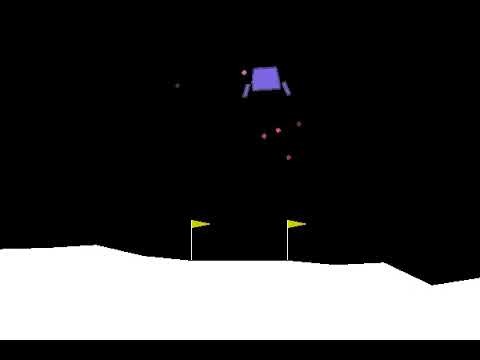

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('itfsi8tTwWU', width=560, height=315)

Of course, this works fine, and the astronauts on board survive the trip down. But are there less obvious (and more exciting) ways to land? Definitely 😉. For instance, we can land it a bit like an airplane:

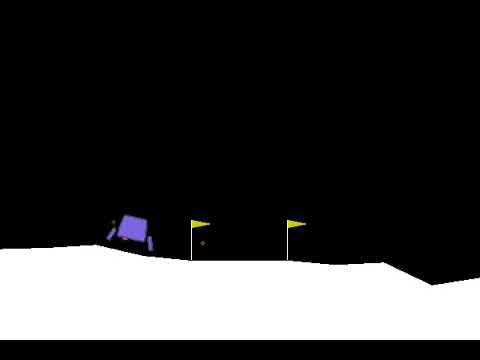

In [2]:
YouTubeVideo('SYDbnH--R1U', width=560, height=315)

The primary difference between these two trajectories is their "point of impact," that is, the x-position when the lunar lander touches the ground for the first time. In the vertical trajectory, the lunar lander first touches the ground at $x \approx -0.1$, while in the airplane trajectory, it touches down at $x \approx -0.6$ (coordinates range from -1 to 1 with 0 at the center of the screen).

Of course, it does not stop there, and we can generate trajectories with a wide variety of impact points. In this tutorial, we will show how to do just that using the pyribs implementation of [CMA-ME](https://arxiv.org/abs/1912.02400).

## Setup

First, we retrieve the dependencies. We freeze our versions in order to make results reproducible. If this command updates or installs any dependencies, you may need to restart the kernel to make sure they are used. We retrieve `ribs[all]` in order to use the `ribs.visualize` module.

In [ ]:
%pip install ribs[all] gym~=0.17.0 Box2D~=2.3.10 tqdm

In [4]:
import time

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from ribs.archives import GridArchive
from ribs.emitters import ImprovementEmitter
from ribs.optimizers import Optimizer
from ribs.visualize import grid_archive_heatmap

## Problem Description

As seen in the introduction, the "impact characteristics" of a lunar lander can make a large difference in its trajectory. To be more specific, we define "impact" to be when either of the lunar lander's legs touches the ground for the first time. When this happens, we are interested in the following properties of the lunar lander:

- $x$-position: This will lead to markedly different trajectories as seen earlier
- $y$-velocity: If the lunar lander is moving very fast when it hits the ground, the astronauts or the lander itself may be injured.

If the lunar lander never impacts the ground, we default the $x$-position to be the last $x$-position of the lander, and the $y$-velocity to be the maximum velocity of the lander (technically, the minimum, since the lander is going down).

We will search for policies that produce high-performing trajectories with these characteristics. In QD terms, the reward is our objective, and the impact characteristics are our behavior characteristics (BCs). For simplicity, we will use a linear policy to control the lunar lander. As the lunar lander has discrete controls, the equation for this policy is:

$$a = argmax(Ws)$$

where $a$ is the action to take, $s$ is the state vector, and $W$ is our model, a matrix of weights that stays constant in each trajectory. Essentially, we transform the state to a vector with a "signal" for each possible action in the action space, and we choose the action with the highest signal. In searching for policies, we will really be searching for different models $W$.

Finally, to ensure we have an environment where landing with different trajectories works all the time (it works best on flat terrains), we have chosen a single seed (seed 1339) to use throughout the experiment, as shown below.

In [5]:
env = gym.make("LunarLander-v2")
seed = 1339  # Flat terrain.
action_dim = env.action_space.n
obs_dim = env.observation_space.shape[0]

We can summarize our problem description with the following `simulate` function, which takes in the model and rolls it out in the Lunar Lander environment.

In [6]:
def simulate(env, model, seed=None):
    """Simulates the lunar lander model and returns total reward and impact

    Args:
        env (gym.Env): A copy of the lunar lander environment.
        model (np.ndarray): The array of weights for the linear policy.
        seed (int): The seed for the environment.
    Returns:
        total_reward (float): The reward accrued by the lander throughout its
            trajectory.
        impact_x_pos (float): The x position of the lander when it touches the
            ground for the first time.
        impact_y_vel (float): The y velocity of the lander when it touches the
            ground for the first time.
    """
    # Seeding the environment ensures simulations are deterministic.
    if seed is not None:
        env.seed(seed)

    action_dim = env.action_space.n
    obs_dim = env.observation_space.shape[0]
    model = model.reshape((action_dim, obs_dim))

    total_reward = 0.0
    timesteps = 0
    obs = env.reset()
    impact_x_pos = None
    all_y_vels = []
    impact_y_vel = None
    done = False

    while not done:
        action = np.argmax(model @ obs)  # Linear policy.
        obs, reward, done, info = env.step(action)
        total_reward += reward

        # Refer to the definition of state here:
        # https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py#L306
        x_pos = obs[0]
        y_vel = obs[3]
        leg0_touch = bool(obs[6])
        leg1_touch = bool(obs[7])
        all_y_vels.append(y_vel)

        # Check if the lunar lander is impacting for the first time.
        if impact_x_pos is None and (leg0_touch or leg1_touch):
            impact_x_pos = x_pos
            impact_y_vel = y_vel

    # If the lunar lander did not land, set the x-pos to the one from the final
    # timestep, and set the y-vel to the maximum y-vel (we use minimum since the
    # lander is going down).
    if impact_x_pos is None:
        impact_x_pos = x_pos
        impact_y_vel = min(all_y_vels)

    return total_reward, impact_x_pos, impact_y_vel

## CMA-ME with pyribs

Covariance Matrix Adaptation MAP-Elites is a Quality-Diversity (QD) algorithm that leverages [CMA-ES](http://cma.gforge.inria.fr) to enhance exploration of the search and behavior space. To use CMA-ME to search for lunar lander policies, we will need the `GridArchive`, `ImprovementEmitter`, and `Optimizer` from pyribs.

First, the `GridArchive` stores solutions in a rectangular grid. Each dimension of the `GridArchive` corresponds to a dimension in behavior space that is segmented into equally sized bins. As we have two BCs for our lunar lander, we have two dimensions in the `GridArchive`. The first dimension is the impact $x$-position, which ranges from -1 to 1, and the second is the impact $y$-velocity, which ranges from -3 (hitting the ground very quickly) to 0 (gently touching down). We divide both BCs into 50 bins below.

In [7]:
archive = GridArchive(
    [50, 50],  # 50 bins in each dimension.
    [(-1.0, 1.0), (-3.0, 0.0)],  # (-1, 1) for x-pos and (-3, 0) for y-vel.
)

Next, the `ImprovementEmitter` uses CMA-ES to search for policies that add new entries to the archive or improve existing ones. Since we do not have any prior knowledge of what the model will be, we set the initial model to be the zero vector, and we set the initial step size for CMA-ES to be 1.0, so that initial solutions are sampled from the standard Gaussian.

In [8]:
initial_model = np.zeros((action_dim, obs_dim))
emitters = [ImprovementEmitter(
    archive,
    initial_model.flatten(),
    1.0, # Initial step size.
)]

Above, we chose not to pass a ``batch_size``, i.e. the number of solutions for the emitter to generate on each call to its ``ask()`` method. Thus, the batch size was automatically calculated. We can check what it is:

In [9]:
print(emitters[0].batch_size)

14


Finally, the ``Optimizer`` connects the archive and emitters together.

In [10]:
optimizer = Optimizer(archive, emitters)

## QD Search

With the pyribs components defined, we can start searching with CMA-ME. This loop should take 1-2 hours to run. Since the emitter has a batch size of 14, and we are running 2500 iterations, so we will have to run 14 x 2500 = 35,000 lunar lander simulations. We also keep track of some logging info.

In [ ]:
start_time = time.time()
total_itrs = 2500

for itr in tqdm(range(1, total_itrs + 1)):
    # Request models from the optimizer.
    sols = optimizer.ask()

    # Evaluate the models and record the objectives and BCs.
    objs, bcs = [], []
    for model in sols:
        obj, impact_x_pos, impact_y_vel = simulate(env, model, seed)
        objs.append(obj)
        bcs.append([impact_x_pos, impact_y_vel])

    # Send the results back to the optimizer.
    optimizer.tell(objs, bcs)

    # Logging.
    if itr % 100 == 0:
        df = archive.as_pandas(include_solutions=False)
        elapsed_time = time.time() - start_time
        print(f"> {itr} itrs completed after {elapsed_time} s")
        print(f"  - Archive Size: {len(df)}")
        print(f"  - Max Score: {df['objective'].max()}")

## Visualizing the Archive

We can visualize our results in a few ways. First, using `grid_archive_heatmap` from `ribs.visualize`, we can see a heatmap of the archive. The heatmap shows the BCs for which CMA-ME found a solution. At each BC, the color of the cell shows the objective value of the solution.

In [ ]:
plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=-300, vmax=300)
plt.gca().invert_yaxis()
plt.ylabel("Impact y-velocity")
plt.xlabel("Impact x-position")

From this heatmap, we can make a few observations:

- CMA-ME found solutions for almost all bins in the archive. Empty bins show up as white.
- Most of the high-performing solutions have lower impact $y$-velocities (see the bright area at the bottom of the map). This is reasonable, as a lander that crashes into the ground probably would not stick the landing.
- The high-performing solutions are spread across a wide range of impact $x$-positions. The highest solutions seem to be at $x \approx 0$ (the bright spot in the middle). This makes sense since an impact $x$-position of 0 corresponds to the direct vertical approach. Nevertheless, there are many high-performing solutions that had other $x$-positions, and we will visualize them in the next section.

## Visualizing Individual Trajectories

To view different models, we can use the OpenAI Gym Monitor to record a video, and we can use IPython to display the video in the notebook.

In [ ]:
import base64
import glob
import io

from IPython.display import display, HTML

First, we can filter the archive for high-performing solutions. To mimic the example at the beginning of this tutorial, we can also filter for solutions with impact positions on the left of the screen (i.e. negative positions).

In [ ]:
df = archive.as_pandas()
sols = df[(df["objective"] > 200) &  # 200 is considered high-performing.
          (df["behavior_0"] < -0.4)  # behavior_0 is the impact x-position.
         ].sort_values("objective", ascending=False)
display(sols)

To visualize some solutions, we pick a row in the archive and extract the solutions.

In [ ]:
rows = sols.head(2)
display(rows.loc[:,:"objective"])
solutions = np.array(rows.loc[:,"solution_0":])

We then construct a video environment with OpenAI gym's Monitor and use it to record videos in the `videos/` directory.

In [ ]:
video_env = gym.wrappers.Monitor(
    gym.make("LunarLander-v2"),
    "videos",
    force=True,  # Overwrite existing videos.
    video_callable=lambda idx: True,  # Make all episodes be recorded.
)

for model in solutions:
    simulate(video_env, model, seed)

# Save video.
video_env.close()

And finally, we display the videos.

In [ ]:
for video_file in glob.iglob("videos/*.mp4"):
    video = io.open(video_file, 'rb').read()
    encoded = base64.b64encode(video).decode("ascii")
    display(HTML(f'''
        <video width="360" height="auto" alt="test" controls>
            <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
        </video>
    '''))

## Conclusion

Often, there are many interesting solutions to a problem, but the properties of these solutions cannot easily be quantified as part of the objective. In such cases, a QD algorithm can help search for solutions that share a wide variety of solutions. In this tutorial, we showed that this is the case for the lunar lander environment. Using CMA-ME, we searched for lunar lander trajectories with a wide variety of impact characteristics. Though these trajectories are vastly different, they all perform well.

For extending this tutorial, we suggest:

- Trying out different terrains by changing the seed. For instance, if the environment has a bunch of valleys, can the lander learn to go into this valley and glide back up?
- Trying different gym environments. What BCs could you use in an environment like `BipedalWalker-v2`?

## Credits

This tutorial is based on a [poster](https://1l7puj10vwe3zflo2jsktkit-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/S20-Klapsis-Poster.pdf) created by Nikitas Klapsis as part of USC's 2020 SHINE program.

## Visualization

In [ ]:
df = archive.as_pandas()
sols = df[(df["objective"] > 200) & (df["behavior_0"] < -0.4)].sort_values("objective", ascending=False)

In [ ]:
print(len(sols))

In [ ]:
# TODO: make into function
i = 0


video_env = gym.wrappers.Monitor(
    gym.make("LunarLander-v2"),
    "videos",
    force=True,  # Overwrite existing videos.
    video_callable=lambda idx: True,  # Make all episodes be recorded.
)

# sol, obj, beh = archive.elite_with_behavior([-0.42, -0.16])
# sol, obj, beh = archive.elite_with_behavior([-0.49, -0.26])
# sol, obj, beh = archive.elite_with_behavior([-0.50, -0.21])
sol = np.array(sols.iloc[i]["solution_0":])

# sol, obj, beh = archive.elite_with_behavior([-0.58, -0.26])
# print(obj)
# print(beh)
simulate(video_env, sol, seed)

# Save videos.
video_env.close()